In [ ]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

In [ ]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170M/170M [00:02<00:00, 76.2MB/s]


In [ ]:
#@title Defining the MLP model
# 3072 (input) → 64 → 128 → 64 → 10 (output)

class MLP(nn.Module):
  def __init__(self, input_size, num_classes, activation_function):
    super(MLP,self).__init__()
    # Defining activation functions and fully-connected layers
    self.activation_function = activation_function
    self.fc_input = nn.Linear(input_size, 128)
    self.dropout1 = nn.Dropout(0.2) #Adicionei 20% de Drop na camada oculta 1
    self.fc_hidden1 = nn.Linear(128, 256)
    self.dropout2 = nn.Dropout(0.4) #40% na camada oculta 2
    self.fc_hidden2 = nn.Linear(256, 128)
    self.dropout3 = nn.Dropout(0.6) #60% na camada oculta 3 (Li que camadas próximas a saída podem se beneficiar de um dropout maior e resolvi experimentar)
    self.fc_hidden3 = nn.Linear(128, 64)
    self.fc_output = nn.Linear(64, num_classes)

  def forward(self,x):
    x = self.activation_function(self.fc_input(x))

    x = self.activation_function(self.fc_hidden1(x))
    x = self.dropout1(x)

    x = self.activation_function(self.fc_hidden2(x))
    x = self.dropout2(x)

    x = self.activation_function(self.fc_hidden3(x))
    x = self.dropout3(x)

    x = self.fc_output(x)
    return x

In [ ]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [ ]:
#@title Hyperparameters
input_size = 32*32*3 # 32x32 RGB images
num_classes = 10

learning_rate = 0.0001 #Diminuir o Learning rate mais ainda
num_epochs = 100 #Voltei a colocar 100 epochs pra ver como funciona tendo feito a adição de Dropouts
batch_size = 16
activation_function = nn.ELU() #Tentar otimizar problemas causados no ReLU

loss_function = nn.CrossEntropyLoss()

In [ ]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#@title Training loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model
mlp = MLP(input_size=input_size, num_classes=num_classes, activation_function=activation_function)
mlp.to(device)

# Setting optimizer up
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=0.0001) #Aqui adicionei uma penalidade a pesos grandes

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0

#Garantir que o modelo de mlp que está ativo é o de treino
mlp.train()

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,32*32*3).to(device) # flattenning images
    labels = labels.to(device)

    # Forward pass
    optimizer.zero_grad()
    outputs = mlp(images)

    # Backward pass
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  epoch_loss /= len(train_loader)
  tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

  # Early stopping using loss value
  if epoch_loss < best_loss:
    best_loss = epoch_loss
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

  0%|          | 0/100 [00:10<?, ?it/s]

 Epoch 1/100, Step 1000/3125, Loss: 1.529512643814087


  0%|          | 0/100 [00:22<?, ?it/s]

 Epoch 1/100, Step 2000/3125, Loss: 2.3382949829101562


  0%|          | 0/100 [00:34<?, ?it/s]

 Epoch 1/100, Step 3000/3125, Loss: 1.4230610132217407


  1%|          | 1/100 [00:35<58:26, 35.41s/it]

Epoch 1 average loss: 1.8758


  1%|          | 1/100 [00:46<58:26, 35.41s/it]

 Epoch 2/100, Step 1000/3125, Loss: 2.1193175315856934


  1%|          | 1/100 [00:58<58:26, 35.41s/it]

 Epoch 2/100, Step 2000/3125, Loss: 1.2662279605865479


  1%|          | 1/100 [01:09<58:26, 35.41s/it]

 Epoch 2/100, Step 3000/3125, Loss: 1.1514654159545898


  2%|▏         | 2/100 [01:10<57:54, 35.45s/it]

Epoch 2 average loss: 1.6707


  2%|▏         | 2/100 [01:22<57:54, 35.45s/it]

 Epoch 3/100, Step 1000/3125, Loss: 1.7408980131149292


  2%|▏         | 2/100 [01:33<57:54, 35.45s/it]

 Epoch 3/100, Step 2000/3125, Loss: 1.6043663024902344


  2%|▏         | 2/100 [01:45<57:54, 35.45s/it]

 Epoch 3/100, Step 3000/3125, Loss: 1.0569283962249756


  3%|▎         | 3/100 [01:46<57:34, 35.61s/it]

Epoch 3 average loss: 1.5779


  3%|▎         | 3/100 [01:58<57:34, 35.61s/it]

 Epoch 4/100, Step 1000/3125, Loss: 1.4678640365600586


  3%|▎         | 3/100 [02:09<57:34, 35.61s/it]

 Epoch 4/100, Step 2000/3125, Loss: 1.506746530532837


  3%|▎         | 3/100 [02:20<57:34, 35.61s/it]

 Epoch 4/100, Step 3000/3125, Loss: 1.5619196891784668


  4%|▍         | 4/100 [02:22<57:00, 35.63s/it]

Epoch 4 average loss: 1.5125


  4%|▍         | 4/100 [02:33<57:00, 35.63s/it]

 Epoch 5/100, Step 1000/3125, Loss: 1.7491204738616943


  4%|▍         | 4/100 [02:44<57:00, 35.63s/it]

 Epoch 5/100, Step 2000/3125, Loss: 1.244509220123291


  4%|▍         | 4/100 [02:55<57:00, 35.63s/it]

 Epoch 5/100, Step 3000/3125, Loss: 1.506605625152588


  5%|▌         | 5/100 [02:57<55:54, 35.31s/it]

Epoch 5 average loss: 1.4654


  5%|▌         | 5/100 [03:08<55:54, 35.31s/it]

 Epoch 6/100, Step 1000/3125, Loss: 1.4995765686035156


  5%|▌         | 5/100 [03:19<55:54, 35.31s/it]

 Epoch 6/100, Step 2000/3125, Loss: 1.242719292640686


  5%|▌         | 5/100 [03:31<55:54, 35.31s/it]

 Epoch 6/100, Step 3000/3125, Loss: 1.249000072479248


  6%|▌         | 6/100 [03:32<55:30, 35.43s/it]

Epoch 6 average loss: 1.4284


  6%|▌         | 6/100 [03:44<55:30, 35.43s/it]

 Epoch 7/100, Step 1000/3125, Loss: 1.5921776294708252


  6%|▌         | 6/100 [03:55<55:30, 35.43s/it]

 Epoch 7/100, Step 2000/3125, Loss: 1.3814929723739624


  6%|▌         | 6/100 [04:06<55:30, 35.43s/it]

 Epoch 7/100, Step 3000/3125, Loss: 1.3783835172653198


  7%|▋         | 7/100 [04:08<54:52, 35.40s/it]

Epoch 7 average loss: 1.3943


  7%|▋         | 7/100 [04:19<54:52, 35.40s/it]

 Epoch 8/100, Step 1000/3125, Loss: 0.9791236519813538


  7%|▋         | 7/100 [04:30<54:52, 35.40s/it]

 Epoch 8/100, Step 2000/3125, Loss: 1.6009047031402588


  7%|▋         | 7/100 [04:41<54:52, 35.40s/it]

 Epoch 8/100, Step 3000/3125, Loss: 1.5182843208312988


  8%|▊         | 8/100 [04:43<54:11, 35.34s/it]

Epoch 8 average loss: 1.3587


  8%|▊         | 8/100 [04:54<54:11, 35.34s/it]

 Epoch 9/100, Step 1000/3125, Loss: 1.0627074241638184


  8%|▊         | 8/100 [05:05<54:11, 35.34s/it]

 Epoch 9/100, Step 2000/3125, Loss: 1.3878329992294312


  8%|▊         | 8/100 [05:16<54:11, 35.34s/it]

 Epoch 9/100, Step 3000/3125, Loss: 1.4673219919204712


  9%|▉         | 9/100 [05:17<53:14, 35.10s/it]

Epoch 9 average loss: 1.3356


  9%|▉         | 9/100 [05:28<53:14, 35.10s/it]

 Epoch 10/100, Step 1000/3125, Loss: 1.3336076736450195


  9%|▉         | 9/100 [05:40<53:14, 35.10s/it]

 Epoch 10/100, Step 2000/3125, Loss: 1.11691415309906


  9%|▉         | 9/100 [05:52<53:14, 35.10s/it]

 Epoch 10/100, Step 3000/3125, Loss: 1.6213476657867432


 10%|█         | 10/100 [05:54<53:11, 35.46s/it]

Epoch 10 average loss: 1.3098


 10%|█         | 10/100 [06:06<53:11, 35.46s/it]

 Epoch 11/100, Step 1000/3125, Loss: 1.2162010669708252


 10%|█         | 10/100 [06:17<53:11, 35.46s/it]

 Epoch 11/100, Step 2000/3125, Loss: 1.148608684539795


 10%|█         | 10/100 [06:28<53:11, 35.46s/it]

 Epoch 11/100, Step 3000/3125, Loss: 1.5334094762802124


 11%|█         | 11/100 [06:30<52:47, 35.58s/it]

Epoch 11 average loss: 1.2871


 11%|█         | 11/100 [06:41<52:47, 35.58s/it]

 Epoch 12/100, Step 1000/3125, Loss: 1.1343241930007935


 11%|█         | 11/100 [06:52<52:47, 35.58s/it]

 Epoch 12/100, Step 2000/3125, Loss: 0.907171905040741


 11%|█         | 11/100 [07:04<52:47, 35.58s/it]

 Epoch 12/100, Step 3000/3125, Loss: 1.3042470216751099


 12%|█▏        | 12/100 [07:05<52:08, 35.55s/it]

Epoch 12 average loss: 1.2650


 12%|█▏        | 12/100 [07:16<52:08, 35.55s/it]

 Epoch 13/100, Step 1000/3125, Loss: 1.455763578414917


 12%|█▏        | 12/100 [07:28<52:08, 35.55s/it]

 Epoch 13/100, Step 2000/3125, Loss: 1.780109167098999


 12%|█▏        | 12/100 [07:38<52:08, 35.55s/it]

 Epoch 13/100, Step 3000/3125, Loss: 1.4943878650665283


 13%|█▎        | 13/100 [07:40<51:23, 35.44s/it]

Epoch 13 average loss: 1.2413


 13%|█▎        | 13/100 [07:51<51:23, 35.44s/it]

 Epoch 14/100, Step 1000/3125, Loss: 0.8606866002082825


 13%|█▎        | 13/100 [08:02<51:23, 35.44s/it]

 Epoch 14/100, Step 2000/3125, Loss: 1.5780529975891113


 13%|█▎        | 13/100 [08:13<51:23, 35.44s/it]

 Epoch 14/100, Step 3000/3125, Loss: 1.0259650945663452


 14%|█▍        | 14/100 [08:15<50:26, 35.19s/it]

Epoch 14 average loss: 1.2228


 14%|█▍        | 14/100 [08:26<50:26, 35.19s/it]

 Epoch 15/100, Step 1000/3125, Loss: 1.0183151960372925


 14%|█▍        | 14/100 [08:38<50:26, 35.19s/it]

 Epoch 15/100, Step 2000/3125, Loss: 1.7868620157241821


 14%|█▍        | 14/100 [08:49<50:26, 35.19s/it]

 Epoch 15/100, Step 3000/3125, Loss: 1.414715051651001


 15%|█▌        | 15/100 [08:50<49:53, 35.22s/it]

Epoch 15 average loss: 1.1994


 15%|█▌        | 15/100 [09:01<49:53, 35.22s/it]

 Epoch 16/100, Step 1000/3125, Loss: 0.8598885536193848


 15%|█▌        | 15/100 [09:13<49:53, 35.22s/it]

 Epoch 16/100, Step 2000/3125, Loss: 0.9656044244766235


 15%|█▌        | 15/100 [09:24<49:53, 35.22s/it]

 Epoch 16/100, Step 3000/3125, Loss: 0.9275597929954529


 16%|█▌        | 16/100 [09:25<49:21, 35.26s/it]

Epoch 16 average loss: 1.1842


 16%|█▌        | 16/100 [09:37<49:21, 35.26s/it]

 Epoch 17/100, Step 1000/3125, Loss: 0.8312678933143616


 16%|█▌        | 16/100 [09:48<49:21, 35.26s/it]

 Epoch 17/100, Step 2000/3125, Loss: 0.7869789004325867


 16%|█▌        | 16/100 [09:59<49:21, 35.26s/it]

 Epoch 17/100, Step 3000/3125, Loss: 0.9998341202735901


 17%|█▋        | 17/100 [10:00<48:36, 35.14s/it]

Epoch 17 average loss: 1.1691


 17%|█▋        | 17/100 [10:11<48:36, 35.14s/it]

 Epoch 18/100, Step 1000/3125, Loss: 1.453399658203125


 17%|█▋        | 17/100 [10:22<48:36, 35.14s/it]

 Epoch 18/100, Step 2000/3125, Loss: 1.075028896331787


 17%|█▋        | 17/100 [10:34<48:36, 35.14s/it]

 Epoch 18/100, Step 3000/3125, Loss: 1.4288053512573242


 18%|█▊        | 18/100 [10:35<47:55, 35.07s/it]

Epoch 18 average loss: 1.1514


 18%|█▊        | 18/100 [10:47<47:55, 35.07s/it]

 Epoch 19/100, Step 1000/3125, Loss: 1.5283186435699463


 18%|█▊        | 18/100 [10:58<47:55, 35.07s/it]

 Epoch 19/100, Step 2000/3125, Loss: 1.3252102136611938


 18%|█▊        | 18/100 [11:09<47:55, 35.07s/it]

 Epoch 19/100, Step 3000/3125, Loss: 1.7150074243545532


 19%|█▉        | 19/100 [11:11<47:26, 35.14s/it]

Epoch 19 average loss: 1.1362


 19%|█▉        | 19/100 [11:22<47:26, 35.14s/it]

 Epoch 20/100, Step 1000/3125, Loss: 0.8227747082710266


 19%|█▉        | 19/100 [11:33<47:26, 35.14s/it]

 Epoch 20/100, Step 2000/3125, Loss: 1.3602235317230225


 19%|█▉        | 19/100 [11:44<47:26, 35.14s/it]

 Epoch 20/100, Step 3000/3125, Loss: 1.4135233163833618


 20%|██        | 20/100 [11:45<46:46, 35.08s/it]

Epoch 20 average loss: 1.1179


 20%|██        | 20/100 [11:57<46:46, 35.08s/it]

 Epoch 21/100, Step 1000/3125, Loss: 0.9033387303352356


 20%|██        | 20/100 [12:07<46:46, 35.08s/it]

 Epoch 21/100, Step 2000/3125, Loss: 1.2148711681365967


 20%|██        | 20/100 [12:18<46:46, 35.08s/it]

 Epoch 21/100, Step 3000/3125, Loss: 0.9977017641067505


 21%|██        | 21/100 [12:20<45:51, 34.83s/it]

Epoch 21 average loss: 1.1038


 21%|██        | 21/100 [12:31<45:51, 34.83s/it]

 Epoch 22/100, Step 1000/3125, Loss: 1.1876237392425537


 21%|██        | 21/100 [12:42<45:51, 34.83s/it]

 Epoch 22/100, Step 2000/3125, Loss: 1.0867998600006104


 21%|██        | 21/100 [12:53<45:51, 34.83s/it]

 Epoch 22/100, Step 3000/3125, Loss: 1.3733201026916504


 22%|██▏       | 22/100 [12:55<45:19, 34.86s/it]

Epoch 22 average loss: 1.0979


 22%|██▏       | 22/100 [13:06<45:19, 34.86s/it]

 Epoch 23/100, Step 1000/3125, Loss: 0.9276084899902344


 22%|██▏       | 22/100 [13:17<45:19, 34.86s/it]

 Epoch 23/100, Step 2000/3125, Loss: 1.0503860712051392


 22%|██▏       | 22/100 [13:29<45:19, 34.86s/it]

 Epoch 23/100, Step 3000/3125, Loss: 0.7994333505630493


 23%|██▎       | 23/100 [13:30<44:53, 34.98s/it]

Epoch 23 average loss: 1.0729


 23%|██▎       | 23/100 [13:41<44:53, 34.98s/it]

 Epoch 24/100, Step 1000/3125, Loss: 1.4831931591033936


 23%|██▎       | 23/100 [13:53<44:53, 34.98s/it]

 Epoch 24/100, Step 2000/3125, Loss: 1.4558131694793701


 23%|██▎       | 23/100 [14:03<44:53, 34.98s/it]

 Epoch 24/100, Step 3000/3125, Loss: 1.2173207998275757


 24%|██▍       | 24/100 [14:05<44:23, 35.04s/it]

Epoch 24 average loss: 1.0676


 24%|██▍       | 24/100 [14:16<44:23, 35.04s/it]

 Epoch 25/100, Step 1000/3125, Loss: 0.8999925255775452


 24%|██▍       | 24/100 [14:27<44:23, 35.04s/it]

 Epoch 25/100, Step 2000/3125, Loss: 0.9692989587783813


 24%|██▍       | 24/100 [14:38<44:23, 35.04s/it]

 Epoch 25/100, Step 3000/3125, Loss: 1.1021573543548584


 25%|██▌       | 25/100 [14:40<43:34, 34.86s/it]

Epoch 25 average loss: 1.0457


 25%|██▌       | 25/100 [14:51<43:34, 34.86s/it]

 Epoch 26/100, Step 1000/3125, Loss: 0.961493968963623


 25%|██▌       | 25/100 [15:02<43:34, 34.86s/it]

 Epoch 26/100, Step 2000/3125, Loss: 1.6149108409881592


 25%|██▌       | 25/100 [15:13<43:34, 34.86s/it]

 Epoch 26/100, Step 3000/3125, Loss: 0.8058031797409058


 26%|██▌       | 26/100 [15:14<42:59, 34.86s/it]

Epoch 26 average loss: 1.0358


 26%|██▌       | 26/100 [15:26<42:59, 34.86s/it]

 Epoch 27/100, Step 1000/3125, Loss: 1.6729060411453247


 26%|██▌       | 26/100 [15:37<42:59, 34.86s/it]

 Epoch 27/100, Step 2000/3125, Loss: 1.4101108312606812


 26%|██▌       | 26/100 [15:48<42:59, 34.86s/it]

 Epoch 27/100, Step 3000/3125, Loss: 1.34398353099823


 27%|██▋       | 27/100 [15:50<42:33, 34.98s/it]

Epoch 27 average loss: 1.0223


 27%|██▋       | 27/100 [16:01<42:33, 34.98s/it]

 Epoch 28/100, Step 1000/3125, Loss: 1.5879487991333008


 27%|██▋       | 27/100 [16:12<42:33, 34.98s/it]

 Epoch 28/100, Step 2000/3125, Loss: 0.8176368474960327


 27%|██▋       | 27/100 [16:23<42:33, 34.98s/it]

 Epoch 28/100, Step 3000/3125, Loss: 1.2787501811981201


 28%|██▊       | 28/100 [16:25<41:59, 34.99s/it]

Epoch 28 average loss: 1.0106


 28%|██▊       | 28/100 [16:35<41:59, 34.99s/it]

 Epoch 29/100, Step 1000/3125, Loss: 1.0738154649734497


 28%|██▊       | 28/100 [16:46<41:59, 34.99s/it]

 Epoch 29/100, Step 2000/3125, Loss: 1.199865460395813


 28%|██▊       | 28/100 [16:57<41:59, 34.99s/it]

 Epoch 29/100, Step 3000/3125, Loss: 1.4741915464401245


 29%|██▉       | 29/100 [16:59<41:04, 34.71s/it]

Epoch 29 average loss: 1.0014


 29%|██▉       | 29/100 [17:10<41:04, 34.71s/it]

 Epoch 30/100, Step 1000/3125, Loss: 0.7297301292419434


 29%|██▉       | 29/100 [17:21<41:04, 34.71s/it]

 Epoch 30/100, Step 2000/3125, Loss: 1.1545971632003784


 29%|██▉       | 29/100 [17:32<41:04, 34.71s/it]

 Epoch 30/100, Step 3000/3125, Loss: 1.072152853012085


 30%|███       | 30/100 [17:34<40:36, 34.81s/it]

Epoch 30 average loss: 0.9840


 30%|███       | 30/100 [17:45<40:36, 34.81s/it]

 Epoch 31/100, Step 1000/3125, Loss: 1.1999754905700684


 30%|███       | 30/100 [17:56<40:36, 34.81s/it]

 Epoch 31/100, Step 2000/3125, Loss: 0.7933842539787292


 30%|███       | 30/100 [18:07<40:36, 34.81s/it]

 Epoch 31/100, Step 3000/3125, Loss: 1.0300953388214111


 31%|███       | 31/100 [18:09<40:07, 34.89s/it]

Epoch 31 average loss: 0.9779


 31%|███       | 31/100 [18:20<40:07, 34.89s/it]

 Epoch 32/100, Step 1000/3125, Loss: 1.0345104932785034


 31%|███       | 31/100 [18:31<40:07, 34.89s/it]

 Epoch 32/100, Step 2000/3125, Loss: 1.1593111753463745


 31%|███       | 31/100 [18:42<40:07, 34.89s/it]

 Epoch 32/100, Step 3000/3125, Loss: 0.9350405335426331


 32%|███▏      | 32/100 [18:43<39:20, 34.71s/it]

Epoch 32 average loss: 0.9665


 32%|███▏      | 32/100 [18:54<39:20, 34.71s/it]

 Epoch 33/100, Step 1000/3125, Loss: 0.9965447783470154


 32%|███▏      | 32/100 [19:05<39:20, 34.71s/it]

 Epoch 33/100, Step 2000/3125, Loss: 0.8928980231285095


 32%|███▏      | 32/100 [19:17<39:20, 34.71s/it]

 Epoch 33/100, Step 3000/3125, Loss: 0.8777919411659241


 33%|███▎      | 33/100 [19:18<38:50, 34.78s/it]

Epoch 33 average loss: 0.9550


 33%|███▎      | 33/100 [19:29<38:50, 34.78s/it]

 Epoch 34/100, Step 1000/3125, Loss: 0.7517504096031189


 33%|███▎      | 33/100 [19:41<38:50, 34.78s/it]

 Epoch 34/100, Step 2000/3125, Loss: 0.5138428807258606


 33%|███▎      | 33/100 [19:52<38:50, 34.78s/it]

 Epoch 34/100, Step 3000/3125, Loss: 1.1382436752319336


 34%|███▍      | 34/100 [19:53<38:25, 34.94s/it]

Epoch 34 average loss: 0.9482


 34%|███▍      | 34/100 [20:05<38:25, 34.94s/it]

 Epoch 35/100, Step 1000/3125, Loss: 0.8222931623458862


 34%|███▍      | 34/100 [20:16<38:25, 34.94s/it]

 Epoch 35/100, Step 2000/3125, Loss: 1.1567782163619995


 34%|███▍      | 34/100 [20:27<38:25, 34.94s/it]

 Epoch 35/100, Step 3000/3125, Loss: 0.5304084420204163


 35%|███▌      | 35/100 [20:29<38:01, 35.09s/it]

Epoch 35 average loss: 0.9311


 35%|███▌      | 35/100 [20:40<38:01, 35.09s/it]

 Epoch 36/100, Step 1000/3125, Loss: 1.12846040725708


 35%|███▌      | 35/100 [20:51<38:01, 35.09s/it]

 Epoch 36/100, Step 2000/3125, Loss: 0.5968888401985168


 35%|███▌      | 35/100 [21:02<38:01, 35.09s/it]

 Epoch 36/100, Step 3000/3125, Loss: 0.9395137429237366


 36%|███▌      | 36/100 [21:03<37:14, 34.91s/it]

Epoch 36 average loss: 0.9227


 36%|███▌      | 36/100 [21:15<37:14, 34.91s/it]

 Epoch 37/100, Step 1000/3125, Loss: 0.961700439453125


 36%|███▌      | 36/100 [21:26<37:14, 34.91s/it]

 Epoch 37/100, Step 2000/3125, Loss: 0.8884198069572449


 36%|███▌      | 36/100 [21:37<37:14, 34.91s/it]

 Epoch 37/100, Step 3000/3125, Loss: 1.469089388847351


 37%|███▋      | 37/100 [21:38<36:39, 34.91s/it]

Epoch 37 average loss: 0.9117


 37%|███▋      | 37/100 [21:49<36:39, 34.91s/it]

 Epoch 38/100, Step 1000/3125, Loss: 0.7346633672714233


 37%|███▋      | 37/100 [22:01<36:39, 34.91s/it]

 Epoch 38/100, Step 2000/3125, Loss: 1.1028555631637573


 37%|███▋      | 37/100 [22:12<36:39, 34.91s/it]

 Epoch 38/100, Step 3000/3125, Loss: 1.2734274864196777


 38%|███▊      | 38/100 [22:13<36:09, 34.98s/it]

Epoch 38 average loss: 0.8991


 38%|███▊      | 38/100 [22:25<36:09, 34.98s/it]

 Epoch 39/100, Step 1000/3125, Loss: 0.6121005415916443


 38%|███▊      | 38/100 [22:35<36:09, 34.98s/it]

 Epoch 39/100, Step 2000/3125, Loss: 1.4399880170822144


 38%|███▊      | 38/100 [22:46<36:09, 34.98s/it]

 Epoch 39/100, Step 3000/3125, Loss: 0.6146376729011536


 39%|███▉      | 39/100 [22:48<35:27, 34.87s/it]

Epoch 39 average loss: 0.8903


 39%|███▉      | 39/100 [22:59<35:27, 34.87s/it]

 Epoch 40/100, Step 1000/3125, Loss: 1.3167304992675781


 39%|███▉      | 39/100 [23:10<35:27, 34.87s/it]

 Epoch 40/100, Step 2000/3125, Loss: 0.8654745817184448


 39%|███▉      | 39/100 [23:21<35:27, 34.87s/it]

 Epoch 40/100, Step 3000/3125, Loss: 0.8885178565979004


 40%|████      | 40/100 [23:23<34:50, 34.83s/it]

Epoch 40 average loss: 0.8829


 40%|████      | 40/100 [23:34<34:50, 34.83s/it]

 Epoch 41/100, Step 1000/3125, Loss: 0.5688760876655579


 40%|████      | 40/100 [23:45<34:50, 34.83s/it]

 Epoch 41/100, Step 2000/3125, Loss: 1.4135957956314087


 40%|████      | 40/100 [23:56<34:50, 34.83s/it]

 Epoch 41/100, Step 3000/3125, Loss: 0.8798937797546387


 41%|████      | 41/100 [23:58<34:18, 34.89s/it]

Epoch 41 average loss: 0.8733


 41%|████      | 41/100 [24:09<34:18, 34.89s/it]

 Epoch 42/100, Step 1000/3125, Loss: 1.2843390703201294


 41%|████      | 41/100 [24:20<34:18, 34.89s/it]

 Epoch 42/100, Step 2000/3125, Loss: 0.6756929159164429


 41%|████      | 41/100 [24:31<34:18, 34.89s/it]

 Epoch 42/100, Step 3000/3125, Loss: 0.40073728561401367


 42%|████▏     | 42/100 [24:33<33:42, 34.87s/it]

Epoch 42 average loss: 0.8600


 42%|████▏     | 42/100 [24:43<33:42, 34.87s/it]

 Epoch 43/100, Step 1000/3125, Loss: 1.552139163017273


 42%|████▏     | 42/100 [24:54<33:42, 34.87s/it]

 Epoch 43/100, Step 2000/3125, Loss: 0.8205959796905518


 42%|████▏     | 42/100 [25:05<33:42, 34.87s/it]

 Epoch 43/100, Step 3000/3125, Loss: 0.604588508605957


 43%|████▎     | 43/100 [25:06<32:50, 34.56s/it]

Epoch 43 average loss: 0.8574


 43%|████▎     | 43/100 [25:18<32:50, 34.56s/it]

 Epoch 44/100, Step 1000/3125, Loss: 0.29857784509658813


 43%|████▎     | 43/100 [25:29<32:50, 34.56s/it]

 Epoch 44/100, Step 2000/3125, Loss: 1.0505852699279785


 43%|████▎     | 43/100 [25:40<32:50, 34.56s/it]

 Epoch 44/100, Step 3000/3125, Loss: 0.4909413158893585


 44%|████▍     | 44/100 [25:41<32:18, 34.61s/it]

Epoch 44 average loss: 0.8435


 44%|████▍     | 44/100 [25:52<32:18, 34.61s/it]

 Epoch 45/100, Step 1000/3125, Loss: 0.5956325531005859


 44%|████▍     | 44/100 [26:04<32:18, 34.61s/it]

 Epoch 45/100, Step 2000/3125, Loss: 1.5280306339263916


 44%|████▍     | 44/100 [26:15<32:18, 34.61s/it]

 Epoch 45/100, Step 3000/3125, Loss: 0.9622795581817627


 45%|████▌     | 45/100 [26:16<31:48, 34.71s/it]

Epoch 45 average loss: 0.8359


 45%|████▌     | 45/100 [26:27<31:48, 34.71s/it]

 Epoch 46/100, Step 1000/3125, Loss: 0.7206887602806091


 45%|████▌     | 45/100 [26:38<31:48, 34.71s/it]

 Epoch 46/100, Step 2000/3125, Loss: 0.698424756526947


 45%|████▌     | 45/100 [26:49<31:48, 34.71s/it]

 Epoch 46/100, Step 3000/3125, Loss: 0.8539272546768188


 46%|████▌     | 46/100 [26:51<31:17, 34.77s/it]

Epoch 46 average loss: 0.8253


 46%|████▌     | 46/100 [27:02<31:17, 34.77s/it]

 Epoch 47/100, Step 1000/3125, Loss: 0.6206524968147278


 46%|████▌     | 46/100 [27:13<31:17, 34.77s/it]

 Epoch 47/100, Step 2000/3125, Loss: 0.6007438898086548


 46%|████▌     | 46/100 [27:25<31:17, 34.77s/it]

 Epoch 47/100, Step 3000/3125, Loss: 0.41215455532073975


 47%|████▋     | 47/100 [27:26<30:49, 34.90s/it]

Epoch 47 average loss: 0.8233


 47%|████▋     | 47/100 [27:37<30:49, 34.90s/it]

 Epoch 48/100, Step 1000/3125, Loss: 1.1472142934799194


 47%|████▋     | 47/100 [27:49<30:49, 34.90s/it]

 Epoch 48/100, Step 2000/3125, Loss: 0.8744549751281738


 47%|████▋     | 47/100 [28:00<30:49, 34.90s/it]

 Epoch 48/100, Step 3000/3125, Loss: 1.0930109024047852


 48%|████▊     | 48/100 [28:01<30:18, 34.97s/it]

Epoch 48 average loss: 0.8114


 48%|████▊     | 48/100 [28:13<30:18, 34.97s/it]

 Epoch 49/100, Step 1000/3125, Loss: 0.49391475319862366


 48%|████▊     | 48/100 [28:24<30:18, 34.97s/it]

 Epoch 49/100, Step 2000/3125, Loss: 0.8709566593170166


 48%|████▊     | 48/100 [28:35<30:18, 34.97s/it]

 Epoch 49/100, Step 3000/3125, Loss: 1.0332261323928833


 49%|████▉     | 49/100 [28:37<29:47, 35.05s/it]

Epoch 49 average loss: 0.8063


 49%|████▉     | 49/100 [28:48<29:47, 35.05s/it]

 Epoch 50/100, Step 1000/3125, Loss: 1.043651819229126


 49%|████▉     | 49/100 [28:58<29:47, 35.05s/it]

 Epoch 50/100, Step 2000/3125, Loss: 0.7949778437614441


 49%|████▉     | 49/100 [29:10<29:47, 35.05s/it]

 Epoch 50/100, Step 3000/3125, Loss: 1.2130500078201294


 50%|█████     | 50/100 [29:11<29:02, 34.86s/it]

Epoch 50 average loss: 0.8024


 50%|█████     | 50/100 [29:22<29:02, 34.86s/it]

 Epoch 51/100, Step 1000/3125, Loss: 1.1735585927963257


 50%|█████     | 50/100 [29:34<29:02, 34.86s/it]

 Epoch 51/100, Step 2000/3125, Loss: 0.6800029873847961


 50%|█████     | 50/100 [29:45<29:02, 34.86s/it]

 Epoch 51/100, Step 3000/3125, Loss: 0.5715343952178955


 51%|█████     | 51/100 [29:47<28:38, 35.06s/it]

Epoch 51 average loss: 0.7886


 51%|█████     | 51/100 [29:58<28:38, 35.06s/it]

 Epoch 52/100, Step 1000/3125, Loss: 0.7385707497596741


 51%|█████     | 51/100 [30:09<28:38, 35.06s/it]

 Epoch 52/100, Step 2000/3125, Loss: 0.8801761865615845


 51%|█████     | 51/100 [30:21<28:38, 35.06s/it]

 Epoch 52/100, Step 3000/3125, Loss: 0.7322030067443848


 52%|█████▏    | 52/100 [30:22<28:15, 35.32s/it]

Epoch 52 average loss: 0.7793


 52%|█████▏    | 52/100 [30:34<28:15, 35.32s/it]

 Epoch 53/100, Step 1000/3125, Loss: 1.055267333984375


 52%|█████▏    | 52/100 [30:46<28:15, 35.32s/it]

 Epoch 53/100, Step 2000/3125, Loss: 0.4928504228591919


 52%|█████▏    | 52/100 [30:57<28:15, 35.32s/it]

 Epoch 53/100, Step 3000/3125, Loss: 0.8685837984085083


 53%|█████▎    | 53/100 [30:59<27:54, 35.64s/it]

Epoch 53 average loss: 0.7708


 53%|█████▎    | 53/100 [31:10<27:54, 35.64s/it]

 Epoch 54/100, Step 1000/3125, Loss: 0.6910849213600159


 53%|█████▎    | 53/100 [31:22<27:54, 35.64s/it]

 Epoch 54/100, Step 2000/3125, Loss: 0.5688210725784302


 53%|█████▎    | 53/100 [31:32<27:54, 35.64s/it]

 Epoch 54/100, Step 3000/3125, Loss: 1.119346022605896


 54%|█████▍    | 54/100 [31:34<27:14, 35.54s/it]

Epoch 54 average loss: 0.7660


 54%|█████▍    | 54/100 [31:45<27:14, 35.54s/it]

 Epoch 55/100, Step 1000/3125, Loss: 0.6550053358078003


 54%|█████▍    | 54/100 [31:56<27:14, 35.54s/it]

 Epoch 55/100, Step 2000/3125, Loss: 0.5879665017127991


 54%|█████▍    | 54/100 [32:07<27:14, 35.54s/it]

 Epoch 55/100, Step 3000/3125, Loss: 0.3797852098941803


 55%|█████▌    | 55/100 [32:09<26:26, 35.26s/it]

Epoch 55 average loss: 0.7611


 55%|█████▌    | 55/100 [32:20<26:26, 35.26s/it]

 Epoch 56/100, Step 1000/3125, Loss: 1.0614407062530518


 55%|█████▌    | 55/100 [32:32<26:26, 35.26s/it]

 Epoch 56/100, Step 2000/3125, Loss: 0.4148811101913452


 55%|█████▌    | 55/100 [32:43<26:26, 35.26s/it]

 Epoch 56/100, Step 3000/3125, Loss: 0.7915346622467041


 56%|█████▌    | 56/100 [32:44<25:53, 35.30s/it]

Epoch 56 average loss: 0.7530


 56%|█████▌    | 56/100 [32:55<25:53, 35.30s/it]

 Epoch 57/100, Step 1000/3125, Loss: 0.5508438944816589


 56%|█████▌    | 56/100 [33:06<25:53, 35.30s/it]

 Epoch 57/100, Step 2000/3125, Loss: 0.7291016578674316


 56%|█████▌    | 56/100 [33:18<25:53, 35.30s/it]

 Epoch 57/100, Step 3000/3125, Loss: 0.9606019854545593


 57%|█████▋    | 57/100 [33:19<25:14, 35.21s/it]

Epoch 57 average loss: 0.7457


 57%|█████▋    | 57/100 [33:30<25:14, 35.21s/it]

 Epoch 58/100, Step 1000/3125, Loss: 0.9671990275382996


 57%|█████▋    | 57/100 [33:41<25:14, 35.21s/it]

 Epoch 58/100, Step 2000/3125, Loss: 0.6689537167549133


 57%|█████▋    | 57/100 [33:52<25:14, 35.21s/it]

 Epoch 58/100, Step 3000/3125, Loss: 0.9623515605926514


 58%|█████▊    | 58/100 [33:54<24:33, 35.09s/it]

Epoch 58 average loss: 0.7383


 58%|█████▊    | 58/100 [34:05<24:33, 35.09s/it]

 Epoch 59/100, Step 1000/3125, Loss: 0.6531515121459961


 58%|█████▊    | 58/100 [34:16<24:33, 35.09s/it]

 Epoch 59/100, Step 2000/3125, Loss: 0.5965174436569214


 58%|█████▊    | 58/100 [34:27<24:33, 35.09s/it]

 Epoch 59/100, Step 3000/3125, Loss: 0.4433056116104126


 59%|█████▉    | 59/100 [34:28<23:50, 34.89s/it]

Epoch 59 average loss: 0.7343


 59%|█████▉    | 59/100 [34:39<23:50, 34.89s/it]

 Epoch 60/100, Step 1000/3125, Loss: 0.5403763055801392


 59%|█████▉    | 59/100 [34:51<23:50, 34.89s/it]

 Epoch 60/100, Step 2000/3125, Loss: 0.873282253742218


 59%|█████▉    | 59/100 [35:02<23:50, 34.89s/it]

 Epoch 60/100, Step 3000/3125, Loss: 0.653215765953064


 60%|██████    | 60/100 [35:03<23:17, 34.95s/it]

Epoch 60 average loss: 0.7227


 60%|██████    | 60/100 [35:15<23:17, 34.95s/it]

 Epoch 61/100, Step 1000/3125, Loss: 0.4196668267250061


 60%|██████    | 60/100 [35:26<23:17, 34.95s/it]

 Epoch 61/100, Step 2000/3125, Loss: 0.9823232293128967


 60%|██████    | 60/100 [35:37<23:17, 34.95s/it]

 Epoch 61/100, Step 3000/3125, Loss: 1.665696144104004


 61%|██████    | 61/100 [35:38<22:42, 34.95s/it]

Epoch 61 average loss: 0.7205


 61%|██████    | 61/100 [35:49<22:42, 34.95s/it]

 Epoch 62/100, Step 1000/3125, Loss: 0.4318283498287201


 61%|██████    | 61/100 [36:00<22:42, 34.95s/it]

 Epoch 62/100, Step 2000/3125, Loss: 0.8483000993728638


 61%|██████    | 61/100 [36:11<22:42, 34.95s/it]

 Epoch 62/100, Step 3000/3125, Loss: 0.3606342077255249


 62%|██████▏   | 62/100 [36:12<21:57, 34.68s/it]

Epoch 62 average loss: 0.7132


 62%|██████▏   | 62/100 [36:24<21:57, 34.68s/it]

 Epoch 63/100, Step 1000/3125, Loss: 0.6295673251152039


 62%|██████▏   | 62/100 [36:35<21:57, 34.68s/it]

 Epoch 63/100, Step 2000/3125, Loss: 0.5362082719802856


 62%|██████▏   | 62/100 [36:46<21:57, 34.68s/it]

 Epoch 63/100, Step 3000/3125, Loss: 0.4822455048561096


 63%|██████▎   | 63/100 [36:47<21:24, 34.72s/it]

Epoch 63 average loss: 0.7052


 63%|██████▎   | 63/100 [36:58<21:24, 34.72s/it]

 Epoch 64/100, Step 1000/3125, Loss: 0.42647963762283325


 63%|██████▎   | 63/100 [37:09<21:24, 34.72s/it]

 Epoch 64/100, Step 2000/3125, Loss: 0.4657658040523529


 63%|██████▎   | 63/100 [37:21<21:24, 34.72s/it]

 Epoch 64/100, Step 3000/3125, Loss: 0.3953748345375061


 64%|██████▍   | 64/100 [37:22<20:49, 34.70s/it]

Epoch 64 average loss: 0.7013


 64%|██████▍   | 64/100 [37:33<20:49, 34.70s/it]

 Epoch 65/100, Step 1000/3125, Loss: 0.5601633787155151


 64%|██████▍   | 64/100 [37:44<20:49, 34.70s/it]

 Epoch 65/100, Step 2000/3125, Loss: 0.9839774370193481


 64%|██████▍   | 64/100 [37:55<20:49, 34.70s/it]

 Epoch 65/100, Step 3000/3125, Loss: 0.28238117694854736


 65%|██████▌   | 65/100 [37:57<20:16, 34.75s/it]

Epoch 65 average loss: 0.6947


 65%|██████▌   | 65/100 [38:08<20:16, 34.75s/it]

 Epoch 66/100, Step 1000/3125, Loss: 0.5966475605964661


 65%|██████▌   | 65/100 [38:19<20:16, 34.75s/it]

 Epoch 66/100, Step 2000/3125, Loss: 0.1959230899810791


 65%|██████▌   | 65/100 [38:31<20:16, 34.75s/it]

 Epoch 66/100, Step 3000/3125, Loss: 1.053442358970642


 66%|██████▌   | 66/100 [38:32<19:45, 34.87s/it]

Epoch 66 average loss: 0.6873


 66%|██████▌   | 66/100 [38:43<19:45, 34.87s/it]

 Epoch 67/100, Step 1000/3125, Loss: 0.8505500555038452


 66%|██████▌   | 66/100 [38:55<19:45, 34.87s/it]

 Epoch 67/100, Step 2000/3125, Loss: 0.5469280481338501


 66%|██████▌   | 66/100 [39:06<19:45, 34.87s/it]

 Epoch 67/100, Step 3000/3125, Loss: 1.078015685081482


 67%|██████▋   | 67/100 [39:07<19:16, 35.06s/it]

Epoch 67 average loss: 0.6828


 67%|██████▋   | 67/100 [39:19<19:16, 35.06s/it]

 Epoch 68/100, Step 1000/3125, Loss: 0.8518202304840088


 67%|██████▋   | 67/100 [39:30<19:16, 35.06s/it]

 Epoch 68/100, Step 2000/3125, Loss: 0.9518324136734009


 67%|██████▋   | 67/100 [39:41<19:16, 35.06s/it]

 Epoch 68/100, Step 3000/3125, Loss: 0.8203969597816467


 68%|██████▊   | 68/100 [39:42<18:41, 35.04s/it]

Epoch 68 average loss: 0.6726


 68%|██████▊   | 68/100 [39:54<18:41, 35.04s/it]

 Epoch 69/100, Step 1000/3125, Loss: 0.6054306030273438


 68%|██████▊   | 68/100 [40:05<18:41, 35.04s/it]

 Epoch 69/100, Step 2000/3125, Loss: 1.1688930988311768


 68%|██████▊   | 68/100 [40:23<18:41, 35.04s/it]

 Epoch 69/100, Step 3000/3125, Loss: 0.7512041330337524


 69%|██████▉   | 69/100 [40:25<19:15, 37.26s/it]

Epoch 69 average loss: 0.6702


 69%|██████▉   | 69/100 [40:36<19:15, 37.26s/it]

 Epoch 70/100, Step 1000/3125, Loss: 0.9386222958564758


 69%|██████▉   | 69/100 [40:53<19:15, 37.26s/it]

 Epoch 70/100, Step 2000/3125, Loss: 1.1409353017807007


 69%|██████▉   | 69/100 [41:07<19:15, 37.26s/it]

 Epoch 70/100, Step 3000/3125, Loss: 0.3916613757610321


 70%|███████   | 70/100 [41:08<19:30, 39.02s/it]

Epoch 70 average loss: 0.6628


 70%|███████   | 70/100 [41:19<19:30, 39.02s/it]

 Epoch 71/100, Step 1000/3125, Loss: 0.4982661008834839


 70%|███████   | 70/100 [41:30<19:30, 39.02s/it]

 Epoch 71/100, Step 2000/3125, Loss: 0.7542932629585266


 70%|███████   | 70/100 [41:42<19:30, 39.02s/it]

 Epoch 71/100, Step 3000/3125, Loss: 0.5225906372070312


 71%|███████   | 71/100 [41:43<18:15, 37.79s/it]

Epoch 71 average loss: 0.6549


 71%|███████   | 71/100 [41:54<18:15, 37.79s/it]

 Epoch 72/100, Step 1000/3125, Loss: 0.5360731482505798


 71%|███████   | 71/100 [42:06<18:15, 37.79s/it]

 Epoch 72/100, Step 2000/3125, Loss: 0.8646431565284729


 71%|███████   | 71/100 [42:17<18:15, 37.79s/it]

 Epoch 72/100, Step 3000/3125, Loss: 0.5363178849220276


 72%|███████▏  | 72/100 [42:18<17:17, 37.06s/it]

Epoch 72 average loss: 0.6585


 72%|███████▏  | 72/100 [42:29<17:17, 37.06s/it]

 Epoch 73/100, Step 1000/3125, Loss: 0.6282467246055603


 72%|███████▏  | 72/100 [42:40<17:17, 37.06s/it]

 Epoch 73/100, Step 2000/3125, Loss: 0.3542720675468445


 72%|███████▏  | 72/100 [42:54<17:17, 37.06s/it]

 Epoch 73/100, Step 3000/3125, Loss: 0.5370416045188904


 73%|███████▎  | 73/100 [42:56<16:47, 37.33s/it]

Epoch 73 average loss: 0.6505


 73%|███████▎  | 73/100 [43:07<16:47, 37.33s/it]

 Epoch 74/100, Step 1000/3125, Loss: 0.932726263999939


 73%|███████▎  | 73/100 [43:18<16:47, 37.33s/it]

 Epoch 74/100, Step 2000/3125, Loss: 0.7605883479118347


 73%|███████▎  | 73/100 [43:29<16:47, 37.33s/it]

 Epoch 74/100, Step 3000/3125, Loss: 0.5204549431800842


 74%|███████▍  | 74/100 [43:31<15:49, 36.52s/it]

Epoch 74 average loss: 0.6467


 74%|███████▍  | 74/100 [43:42<15:49, 36.52s/it]

 Epoch 75/100, Step 1000/3125, Loss: 0.8864132761955261


 74%|███████▍  | 74/100 [43:53<15:49, 36.52s/it]

 Epoch 75/100, Step 2000/3125, Loss: 0.5210959911346436


 74%|███████▍  | 74/100 [44:04<15:49, 36.52s/it]

 Epoch 75/100, Step 3000/3125, Loss: 0.5235061645507812


 75%|███████▌  | 75/100 [44:06<14:59, 35.99s/it]

Epoch 75 average loss: 0.6438


 75%|███████▌  | 75/100 [44:17<14:59, 35.99s/it]

 Epoch 76/100, Step 1000/3125, Loss: 1.0819153785705566


 75%|███████▌  | 75/100 [44:28<14:59, 35.99s/it]

 Epoch 76/100, Step 2000/3125, Loss: 0.6398664712905884


 75%|███████▌  | 75/100 [44:39<14:59, 35.99s/it]

 Epoch 76/100, Step 3000/3125, Loss: 0.1632729321718216


 76%|███████▌  | 76/100 [44:40<14:13, 35.56s/it]

Epoch 76 average loss: 0.6382


 76%|███████▌  | 76/100 [44:51<14:13, 35.56s/it]

 Epoch 77/100, Step 1000/3125, Loss: 0.48499369621276855


 76%|███████▌  | 76/100 [45:02<14:13, 35.56s/it]

 Epoch 77/100, Step 2000/3125, Loss: 0.8535096645355225


 76%|███████▌  | 76/100 [45:13<14:13, 35.56s/it]

 Epoch 77/100, Step 3000/3125, Loss: 0.8130658864974976


 77%|███████▋  | 77/100 [45:15<13:32, 35.33s/it]

Epoch 77 average loss: 0.6372


 77%|███████▋  | 77/100 [45:25<13:32, 35.33s/it]

 Epoch 78/100, Step 1000/3125, Loss: 0.7618526816368103


 77%|███████▋  | 77/100 [45:37<13:32, 35.33s/it]

 Epoch 78/100, Step 2000/3125, Loss: 0.7555096745491028


 77%|███████▋  | 77/100 [45:48<13:32, 35.33s/it]

 Epoch 78/100, Step 3000/3125, Loss: 0.8663771748542786


 78%|███████▊  | 78/100 [45:50<12:53, 35.15s/it]

Epoch 78 average loss: 0.6241


 78%|███████▊  | 78/100 [46:01<12:53, 35.15s/it]

 Epoch 79/100, Step 1000/3125, Loss: 0.8761500120162964


 78%|███████▊  | 78/100 [46:12<12:53, 35.15s/it]

 Epoch 79/100, Step 2000/3125, Loss: 0.5058940649032593


 78%|███████▊  | 78/100 [46:23<12:53, 35.15s/it]

 Epoch 79/100, Step 3000/3125, Loss: 0.5861109495162964


 79%|███████▉  | 79/100 [46:24<12:14, 34.98s/it]

Epoch 79 average loss: 0.6163


 79%|███████▉  | 79/100 [46:35<12:14, 34.98s/it]

 Epoch 80/100, Step 1000/3125, Loss: 0.5139486789703369


 79%|███████▉  | 79/100 [46:46<12:14, 34.98s/it]

 Epoch 80/100, Step 2000/3125, Loss: 0.4329717457294464


 79%|███████▉  | 79/100 [46:57<12:14, 34.98s/it]

 Epoch 80/100, Step 3000/3125, Loss: 0.7093719244003296


 80%|████████  | 80/100 [46:59<11:35, 34.78s/it]

Epoch 80 average loss: 0.6171


 80%|████████  | 80/100 [47:09<11:35, 34.78s/it]

 Epoch 81/100, Step 1000/3125, Loss: 0.12249698489904404


 80%|████████  | 80/100 [47:20<11:35, 34.78s/it]

 Epoch 81/100, Step 2000/3125, Loss: 0.5601456165313721


 80%|████████  | 80/100 [47:31<11:35, 34.78s/it]

 Epoch 81/100, Step 3000/3125, Loss: 0.5428169965744019


 81%|████████  | 81/100 [47:32<10:54, 34.43s/it]

Epoch 81 average loss: 0.6084


 81%|████████  | 81/100 [47:43<10:54, 34.43s/it]

 Epoch 82/100, Step 1000/3125, Loss: 0.9509218335151672


 81%|████████  | 81/100 [47:54<10:54, 34.43s/it]

 Epoch 82/100, Step 2000/3125, Loss: 0.6613434553146362


 81%|████████  | 81/100 [48:05<10:54, 34.43s/it]

 Epoch 82/100, Step 3000/3125, Loss: 0.9515038132667542


 82%|████████▏ | 82/100 [48:07<10:19, 34.41s/it]

Epoch 82 average loss: 0.6089


 82%|████████▏ | 82/100 [48:18<10:19, 34.41s/it]

 Epoch 83/100, Step 1000/3125, Loss: 0.2839321792125702


 82%|████████▏ | 82/100 [48:29<10:19, 34.41s/it]

 Epoch 83/100, Step 2000/3125, Loss: 0.34893277287483215


 82%|████████▏ | 82/100 [48:40<10:19, 34.41s/it]

 Epoch 83/100, Step 3000/3125, Loss: 0.6819749474525452


 83%|████████▎ | 83/100 [48:41<09:44, 34.40s/it]

Epoch 83 average loss: 0.6034


 83%|████████▎ | 83/100 [48:52<09:44, 34.40s/it]

 Epoch 84/100, Step 1000/3125, Loss: 0.6793981790542603


 83%|████████▎ | 83/100 [49:02<09:44, 34.40s/it]

 Epoch 84/100, Step 2000/3125, Loss: 0.3119295537471771


 83%|████████▎ | 83/100 [49:13<09:44, 34.40s/it]

 Epoch 84/100, Step 3000/3125, Loss: 0.950772762298584


 84%|████████▍ | 84/100 [49:15<09:07, 34.21s/it]

Epoch 84 average loss: 0.5995


 84%|████████▍ | 84/100 [49:26<09:07, 34.21s/it]

 Epoch 85/100, Step 1000/3125, Loss: 0.5844889879226685


 84%|████████▍ | 84/100 [49:37<09:07, 34.21s/it]

 Epoch 85/100, Step 2000/3125, Loss: 0.6690771579742432


 84%|████████▍ | 84/100 [49:48<09:07, 34.21s/it]

 Epoch 85/100, Step 3000/3125, Loss: 0.6254042983055115


 85%|████████▌ | 85/100 [49:49<08:35, 34.38s/it]

Epoch 85 average loss: 0.5935


 85%|████████▌ | 85/100 [50:01<08:35, 34.38s/it]

 Epoch 86/100, Step 1000/3125, Loss: 0.5518973469734192


 85%|████████▌ | 85/100 [50:12<08:35, 34.38s/it]

 Epoch 86/100, Step 2000/3125, Loss: 0.21522903442382812


 85%|████████▌ | 85/100 [50:23<08:35, 34.38s/it]

 Epoch 86/100, Step 3000/3125, Loss: 0.6313132643699646


 86%|████████▌ | 86/100 [50:24<08:02, 34.48s/it]

Epoch 86 average loss: 0.5902


 86%|████████▌ | 86/100 [50:35<08:02, 34.48s/it]

 Epoch 87/100, Step 1000/3125, Loss: 0.2815087139606476


 86%|████████▌ | 86/100 [50:46<08:02, 34.48s/it]

 Epoch 87/100, Step 2000/3125, Loss: 0.554355800151825


 86%|████████▌ | 86/100 [50:57<08:02, 34.48s/it]

 Epoch 87/100, Step 3000/3125, Loss: 0.7172843217849731


 87%|████████▋ | 87/100 [50:58<07:27, 34.39s/it]

Epoch 87 average loss: 0.5804


 87%|████████▋ | 87/100 [51:09<07:27, 34.39s/it]

 Epoch 88/100, Step 1000/3125, Loss: 0.4598797857761383


 87%|████████▋ | 87/100 [51:20<07:27, 34.39s/it]

 Epoch 88/100, Step 2000/3125, Loss: 0.8096007108688354


 87%|████████▋ | 87/100 [51:31<07:27, 34.39s/it]

 Epoch 88/100, Step 3000/3125, Loss: 0.22910496592521667


 88%|████████▊ | 88/100 [51:33<06:52, 34.38s/it]

Epoch 88 average loss: 0.5841


 88%|████████▊ | 88/100 [51:44<06:52, 34.38s/it]

 Epoch 89/100, Step 1000/3125, Loss: 0.42593061923980713


 88%|████████▊ | 88/100 [51:55<06:52, 34.38s/it]

 Epoch 89/100, Step 2000/3125, Loss: 0.6877063512802124


 88%|████████▊ | 88/100 [52:06<06:52, 34.38s/it]

 Epoch 89/100, Step 3000/3125, Loss: 0.7602262496948242


 89%|████████▉ | 89/100 [52:08<06:19, 34.51s/it]

Epoch 89 average loss: 0.5748


 89%|████████▉ | 89/100 [52:19<06:19, 34.51s/it]

 Epoch 90/100, Step 1000/3125, Loss: 0.369688481092453


 89%|████████▉ | 89/100 [52:30<06:19, 34.51s/it]

 Epoch 90/100, Step 2000/3125, Loss: 0.43478214740753174


 89%|████████▉ | 89/100 [52:41<06:19, 34.51s/it]

 Epoch 90/100, Step 3000/3125, Loss: 1.5379780530929565


 90%|█████████ | 90/100 [52:43<05:46, 34.69s/it]

Epoch 90 average loss: 0.5719


 90%|█████████ | 90/100 [52:54<05:46, 34.69s/it]

 Epoch 91/100, Step 1000/3125, Loss: 0.7712889909744263


 90%|█████████ | 90/100 [53:05<05:46, 34.69s/it]

 Epoch 91/100, Step 2000/3125, Loss: 0.2299492210149765


 90%|█████████ | 90/100 [53:17<05:46, 34.69s/it]

 Epoch 91/100, Step 3000/3125, Loss: 0.9743445515632629


 91%|█████████ | 91/100 [53:18<05:13, 34.87s/it]

Epoch 91 average loss: 0.5672


 91%|█████████ | 91/100 [53:29<05:13, 34.87s/it]

 Epoch 92/100, Step 1000/3125, Loss: 0.6398072242736816


 91%|█████████ | 91/100 [53:40<05:13, 34.87s/it]

 Epoch 92/100, Step 2000/3125, Loss: 0.21295778453350067


 91%|█████████ | 91/100 [53:51<05:13, 34.87s/it]

 Epoch 92/100, Step 3000/3125, Loss: 0.45919835567474365


 92%|█████████▏| 92/100 [53:53<04:39, 34.89s/it]

Epoch 92 average loss: 0.5604


 92%|█████████▏| 92/100 [54:04<04:39, 34.89s/it]

 Epoch 93/100, Step 1000/3125, Loss: 0.628051221370697


 92%|█████████▏| 92/100 [54:16<04:39, 34.89s/it]

 Epoch 93/100, Step 2000/3125, Loss: 0.2943294942378998


 92%|█████████▏| 92/100 [54:27<04:39, 34.89s/it]

 Epoch 93/100, Step 3000/3125, Loss: 0.5180811285972595


 93%|█████████▎| 93/100 [54:28<04:05, 35.11s/it]

Epoch 93 average loss: 0.5594


 93%|█████████▎| 93/100 [54:40<04:05, 35.11s/it]

 Epoch 94/100, Step 1000/3125, Loss: 0.6303835511207581


 93%|█████████▎| 93/100 [54:51<04:05, 35.11s/it]

 Epoch 94/100, Step 2000/3125, Loss: 0.8529154062271118


 93%|█████████▎| 93/100 [55:02<04:05, 35.11s/it]

 Epoch 94/100, Step 3000/3125, Loss: 0.4187786877155304


 94%|█████████▍| 94/100 [55:04<03:30, 35.11s/it]

Epoch 94 average loss: 0.5600


 94%|█████████▍| 94/100 [55:14<03:30, 35.11s/it]

 Epoch 95/100, Step 1000/3125, Loss: 0.7082602977752686


 94%|█████████▍| 94/100 [55:25<03:30, 35.11s/it]

 Epoch 95/100, Step 2000/3125, Loss: 1.1577967405319214


 94%|█████████▍| 94/100 [55:36<03:30, 35.11s/it]

 Epoch 95/100, Step 3000/3125, Loss: 0.33743250370025635


 95%|█████████▌| 95/100 [55:38<02:53, 34.76s/it]

Epoch 95 average loss: 0.5486


 95%|█████████▌| 95/100 [55:49<02:53, 34.76s/it]

 Epoch 96/100, Step 1000/3125, Loss: 0.27157530188560486


 95%|█████████▌| 95/100 [56:00<02:53, 34.76s/it]

 Epoch 96/100, Step 2000/3125, Loss: 0.3494683504104614


 95%|█████████▌| 95/100 [56:11<02:53, 34.76s/it]

 Epoch 96/100, Step 3000/3125, Loss: 0.5038095116615295


 96%|█████████▌| 96/100 [56:13<02:19, 34.86s/it]

Epoch 96 average loss: 0.5458


 96%|█████████▌| 96/100 [56:24<02:19, 34.86s/it]

 Epoch 97/100, Step 1000/3125, Loss: 0.46109914779663086


 96%|█████████▌| 96/100 [56:35<02:19, 34.86s/it]

 Epoch 97/100, Step 2000/3125, Loss: 0.28390923142433167


 96%|█████████▌| 96/100 [56:46<02:19, 34.86s/it]

 Epoch 97/100, Step 3000/3125, Loss: 0.5461273193359375


 97%|█████████▋| 97/100 [56:48<01:44, 34.94s/it]

Epoch 97 average loss: 0.5481


 97%|█████████▋| 97/100 [56:59<01:44, 34.94s/it]

 Epoch 98/100, Step 1000/3125, Loss: 0.2745780944824219


 97%|█████████▋| 97/100 [57:10<01:44, 34.94s/it]

 Epoch 98/100, Step 2000/3125, Loss: 0.6048405170440674


 97%|█████████▋| 97/100 [57:21<01:44, 34.94s/it]

 Epoch 98/100, Step 3000/3125, Loss: 0.38756105303764343


 98%|█████████▊| 98/100 [57:22<01:09, 34.87s/it]

Epoch 98 average loss: 0.5354


 98%|█████████▊| 98/100 [57:33<01:09, 34.87s/it]

 Epoch 99/100, Step 1000/3125, Loss: 0.22945192456245422


 98%|█████████▊| 98/100 [57:45<01:09, 34.87s/it]

 Epoch 99/100, Step 2000/3125, Loss: 0.8919299840927124


 98%|█████████▊| 98/100 [57:56<01:09, 34.87s/it]

 Epoch 99/100, Step 3000/3125, Loss: 0.5343899726867676


 99%|█████████▉| 99/100 [57:57<00:34, 34.87s/it]

Epoch 99 average loss: 0.5375


 99%|█████████▉| 99/100 [58:09<00:34, 34.87s/it]

 Epoch 100/100, Step 1000/3125, Loss: 0.49399009346961975


 99%|█████████▉| 99/100 [58:20<00:34, 34.87s/it]

 Epoch 100/100, Step 2000/3125, Loss: 0.42818108201026917


 99%|█████████▉| 99/100 [58:31<00:34, 34.87s/it]

 Epoch 100/100, Step 3000/3125, Loss: 0.3989498019218445


100%|██████████| 100/100 [58:33<00:00, 35.13s/it]

Epoch 100 average loss: 0.5326


In [ ]:
#@title Evaluate model (accuracy, precision, recall)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp.eval()
predictions = []
labels = []
for images, label in test_loader:
  images = images.view(-1,32*32*3).to(device)
  label = label.to(device)

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)

for element in scores:
  print(f"{element}: {scores[element]}")

accuracy: 0.5271
balanced_accuracy: 0.5271
precision: 0.5290606072333911
recall: 0.5271
f1_score: 0.5275481902528131


## Matrix Confusão

In [ ]:
from sklearn.metrics import accuracy_score
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        #images, labels = images.to(device), labels.to(device)
        images = images.view(-1,32*32*3).to(device)
        labels = labels.to(device)
        outputs = mlp(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {acc * 100:.2f}%')

Test Accuracy: 52.71%


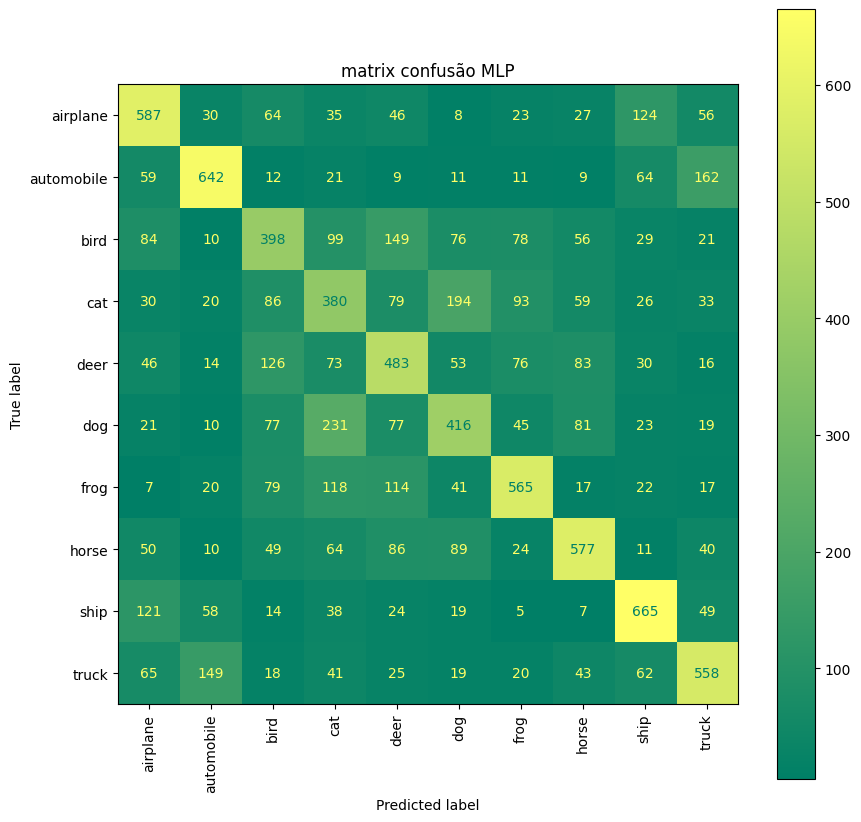

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')
plt.title('matrix confusão MLP')
plt.show()

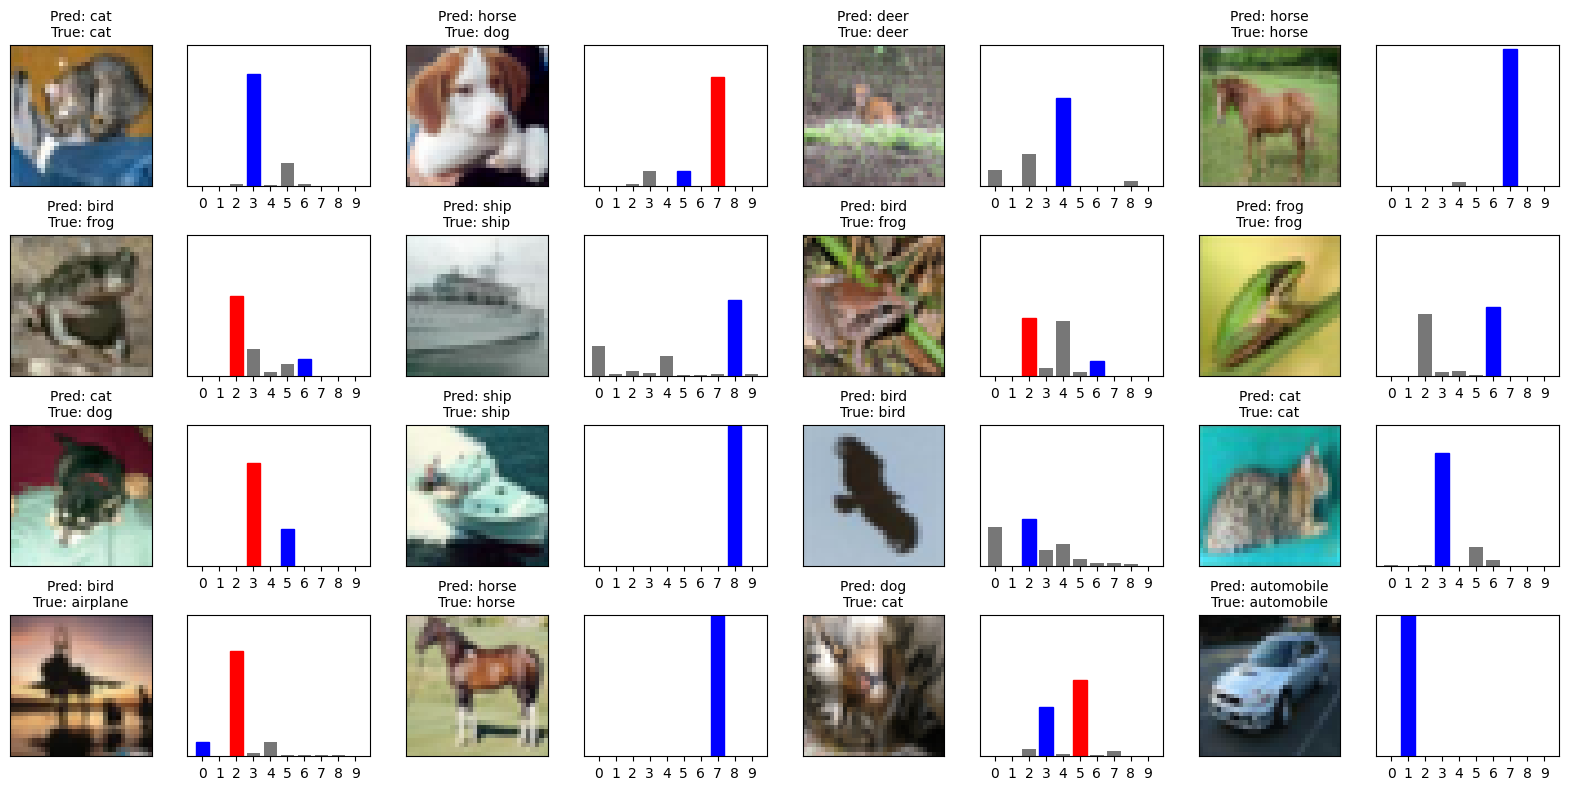

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

def plot_value_array(predictions_array, true_label):
    true_label = int(true_label)
    predicted_label = np.argmax(predictions_array)

    plt.grid(False)
    plt.xticks(range(len(predictions_array)))
    plt.yticks([])
    bars = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
    plt.ylim([0, 1])

    bars[predicted_label].set_color('red')
    bars[true_label].set_color('blue')

mlp.eval()
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

fig = plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

y_pred = []
y_true = []

with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        if i >= num_images:
            break

        image_vis = image[0].cpu() * 0.5 + 0.5
        image_vis = image_vis.permute(1, 2, 0)

        # Classificar com o modelo
        image_input = image.view(image.size(0), -1).to(device)  # achata para o MLP
        output = mlp(image_input)
        probabilities = F.softmax(output, dim=1)[0]
        _, predicted = torch.max(output, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(label.cpu().numpy())

        # Plot da imagem classificada
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        true_label = label[0].item()
        pred_label = predicted[0].item()
        title = f'Pred: {test_dataset.classes[pred_label]}\nTrue: {test_dataset.classes[true_label]}'
        plt.title(title, fontsize=10)
        plt.imshow(image_vis)

        # Plot do gráfico de probabilidade
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(probabilities, true_label)

plt.tight_layout()
plt.show()


In [ ]:
torch.save(mlp.state_dict(), 'mlp_CIFAR_10.pth')
